Columns in the dataframe:
Index(['daily_revenue'], dtype='object')
First 5 rows of the dataframe:
            daily_revenue
date                     
2015-01-03         16.448
2015-01-04        288.060
2015-01-05         19.536
2015-01-06       4407.100
2015-01-07         87.158
Plotting the raw data...


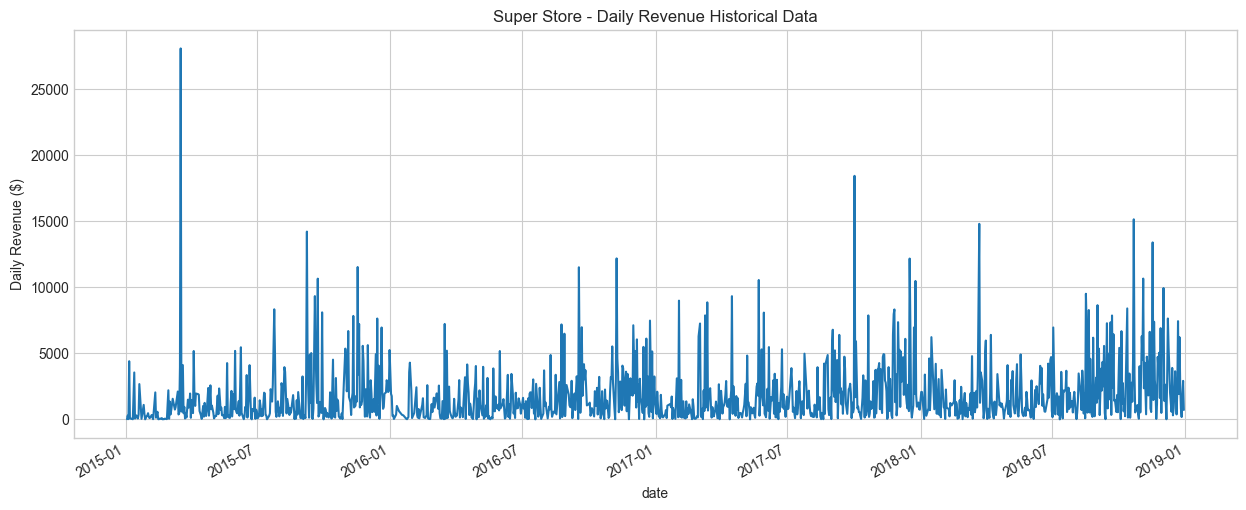

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Import our custom modules
from src.data_generator import generate_sales_data
from src.feature_engineering import create_features
from src.model_trainer import train_linear_regression, train_random_forest, train_final_model, save_model
from src.evaluation import evaluate_model, perform_time_series_cv, plot_predictions
from src.business_value import calculate_business_value

# Define file paths session_1_sales_forecasting\implement\data\super_store_sales\sales_by_order_date.csv
DATA_DIR = 'data/super_store_sales'
MODEL_DIR = 'models'
DATA_FILE = os.path.join(DATA_DIR, 'sales_by_order_date.csv')
MODEL_FILE = os.path.join(MODEL_DIR, 'super_store_forecaster_w.pkl')

# Generate and load data
# generate_sales_data(DATA_FILE)
df = pd.read_csv(DATA_FILE, parse_dates=['date'])
df.set_index('date', inplace=True)
print('Columns in the dataframe:')
print(df.columns)
print('First 5 rows of the dataframe:')
print(df.head())

# Plot the raw data
print('Plotting the raw data...')
plt.style.use('seaborn-v0_8-whitegrid')
df['daily_revenue'].plot(figsize=(15, 6), title="Super Store - Daily Revenue Historical Data")
plt.ylabel('Daily Revenue ($)')
plt.show()


In [2]:
featured_df = create_features(df.reset_index())
print("Columns in our new dataset:")
print(featured_df.columns)
print("\nFirst 5 rows of the new data:")
print(featured_df.head())

# Save the featured dataframe to a csv file
FEATURED_DATA_FILE = os.path.join(DATA_DIR, 'super_store_sales_featured.csv')
featured_df.to_csv(FEATURED_DATA_FILE, index=False)
print(f"\nFeatured data saved to {FEATURED_DATA_FILE}")


Columns in our new dataset:
Index(['daily_revenue', 'day_of_week', 'month', 'year', 'quarter',
       'day_of_year', 'day_of_week_sin', 'day_of_week_cos', 'month_sin',
       'month_cos', 'lag_1', 'lag_7', 'lag_30', 'rolling_mean_7',
       'rolling_mean_30'],
      dtype='object')

First 5 rows of the new data:
            daily_revenue  day_of_week  month  year  quarter  day_of_year  \
date                                                                        
2015-02-14        576.726            5      2  2015        1           45   
2015-02-15         21.360            6      2  2015        1           46   
2015-02-16          9.040            0      2  2015        1           47   
2015-02-17         54.208            1      2  2015        1           48   
2015-02-18         37.784            2      2  2015        1           49   

            day_of_week_sin  day_of_week_cos  month_sin  month_cos    lag_1  \
date                                                               

Training Linear Regression model...
Training complete.
Model Evaluation Results:
Mean Absolute Error (MAE): $2160.88
Root Mean Squared Error (RMSE): $2964.71
------------------------------
Interpretation:
On average, the model's predictions are off by about $2160.88.
RMSE is higher because it penalizes larger errors more heavily.


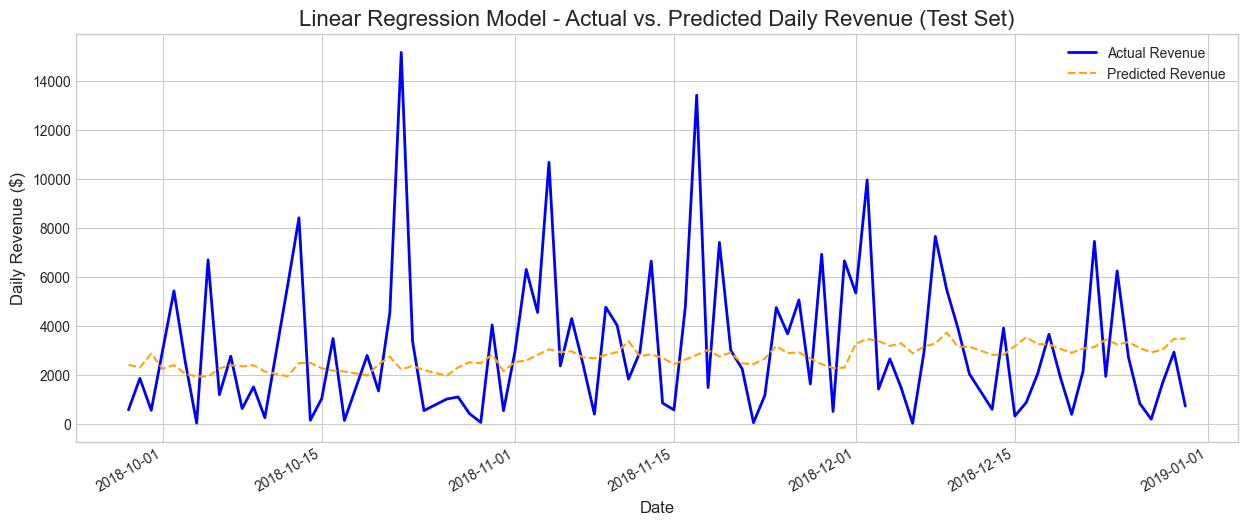

Linear Regression predictions saved to data/super_store_sales\linear_regression_predictions.csv


In [3]:
# lr_model, X_test_lr, y_test_lr = train_linear_regression(featured_df)
lr_model, X_test_lr, y_test_lr = train_linear_regression(featured_df, test_size=90)
lr_results = evaluate_model(lr_model, X_test_lr, y_test_lr)
plot_predictions(lr_results, title="Linear Regression Model - Actual vs. Predicted Daily Revenue (Test Set)")

# Save Linear Regression results
LR_RESULTS_FILE = os.path.join(DATA_DIR, 'linear_regression_predictions.csv')
lr_results.to_csv(LR_RESULTS_FILE, index=True)
print(f"Linear Regression predictions saved to {LR_RESULTS_FILE}")


Training Random Forest with data shape: (1110, 14)
Model training completed.
Model Evaluation Results:
Mean Absolute Error (MAE): $2328.78
Root Mean Squared Error (RMSE): $3092.80
------------------------------
Interpretation:
On average, the model's predictions are off by about $2328.78.
RMSE is higher because it penalizes larger errors more heavily.


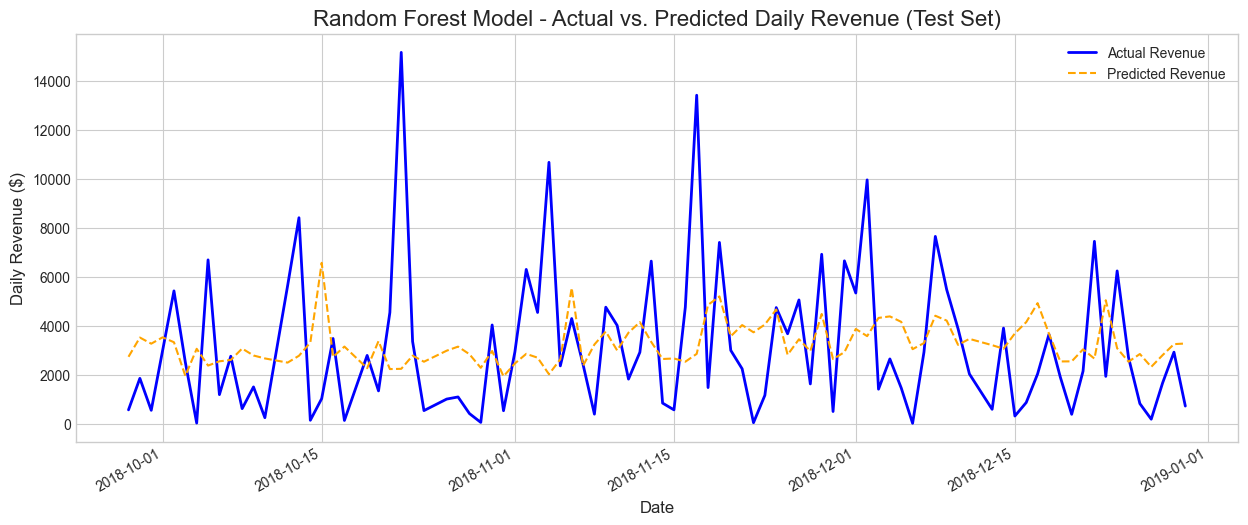

Random Forest predictions saved to data/super_store_sales\random_forest_predictions.csv


In [4]:
# rf_model, X_test_rf, y_test_rf = train_random_forest(featured_df)
rf_model, X_test_rf, y_test_rf = train_random_forest(featured_df, test_size=90)
rf_results = evaluate_model(rf_model, X_test_rf, y_test_rf)
plot_predictions(rf_results, title="Random Forest Model - Actual vs. Predicted Daily Revenue (Test Set)")

# Save Random Forest results
RF_RESULTS_FILE = os.path.join(DATA_DIR, 'random_forest_predictions.csv')
rf_results.to_csv(RF_RESULTS_FILE, index=True)
print(f"Random Forest predictions saved to {RF_RESULTS_FILE}")


In [5]:
print("--- Running CV for Linear Regression ---")
lr_cv_model = LinearRegression()
lr_cv_results = perform_time_series_cv(lr_cv_model, featured_df)

# Save Linear Regression CV results
LR_CV_RESULTS_FILE = os.path.join(DATA_DIR, 'linear_regression_cv_predictions.csv')
# lr_cv_results.to_csv(LR_CV_RESULTS_FILE, index=True)
print(f"Linear Regression CV predictions saved to {LR_CV_RESULTS_FILE}")


--- Running CV for Linear Regression ---
Performing Time Series Cross-Validation with 5 splits...
------------------------------------------------------------
Fold 1/5 | Train: 200 | Test: 200 | MAE: $1625.43 | RMSE: $2032.54
Fold 2/5 | Train: 400 | Test: 200 | MAE: $1226.77 | RMSE: $1843.40


Fold 3/5 | Train: 600 | Test: 200 | MAE: $1357.54 | RMSE: $2308.47
Fold 4/5 | Train: 800 | Test: 200 | MAE: $1546.81 | RMSE: $2204.62
Fold 5/5 | Train: 1000 | Test: 200 | MAE: $1815.77 | RMSE: $2549.93
------------------------------------------------------------
Average CV MAE: $1514.47
Average CV RMSE: $2187.79
Linear Regression CV predictions saved to data/super_store_sales\linear_regression_cv_predictions.csv


In [6]:
print("\n--- Running CV for Random Forest ---")
rf_cv_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)
rf_cv_results = perform_time_series_cv(rf_cv_model, featured_df)

# Save Random Forest CV results
RF_CV_RESULTS_FILE = os.path.join(DATA_DIR, 'random_forest_cv_predictions.csv')
# rf_cv_results.to_csv(RF_CV_RESULTS_FILE, index=True)
print(f"Random Forest CV predictions saved to {RF_CV_RESULTS_FILE}")



--- Running CV for Random Forest ---
Performing Time Series Cross-Validation with 5 splits...
------------------------------------------------------------
Fold 1/5 | Train: 200 | Test: 200 | MAE: $1403.05 | RMSE: $2187.02
Fold 2/5 | Train: 400 | Test: 200 | MAE: $1288.25 | RMSE: $1877.79
Fold 3/5 | Train: 600 | Test: 200 | MAE: $1372.82 | RMSE: $2294.17
Fold 4/5 | Train: 800 | Test: 200 | MAE: $1615.02 | RMSE: $2313.72
Fold 5/5 | Train: 1000 | Test: 200 | MAE: $1909.04 | RMSE: $2622.03
------------------------------------------------------------
Average CV MAE: $1517.64
Average CV RMSE: $2258.95
Random Forest CV predictions saved to data/super_store_sales\random_forest_cv_predictions.csv


In [7]:
final_model = train_final_model(featured_df, model_type='rf')  # model_type can be 'rf' (Random Forest) or 'lr' (Linear Regression)
save_model(final_model, MODEL_FILE)


Training final RF model on entire dataset (shape: (1200, 14))...
Final model training completed.
Model saved successfully to models\super_store_forecaster_w.pkl


In [8]:
# Add 'error' column for business value calculation
rf_cv_results['error'] = rf_cv_results['actual_revenue'] - rf_cv_results['predicted_revenue']
calculate_business_value(rf_cv_results)


Business Value Analysis (Estimated)
----------------------------------------
Assumptions:
  - Cost of overstocking (waste, etc.): 12.0% of over-predicted revenue
  - Cost of understocking (missed sales): 20.0% of under-predicted revenue
  - Even with AI, we still have some error in our predictions (error_rate): 10.0%
----------------------------------------
Average Daily Cost of Prediction Errors with AI Model: $1,517.64
Estimated Daily Cost of Errors without AI Model: $624.00
----------------------------------------
Estimated Daily Savings with AI Forecasting: $-1,045.40
Estimated Annual Savings with AI Forecasting: $-381,572.31
----------------------------------------

Conclusion:
By providing more accurate sales forecasts, the AI model helps Maya's Coffee Chain
optimize inventory and staffing, directly reducing daily operational costs and
translating into significant annual savings.


In [9]:
# Import the predictor module
from src.predictor import load_model, predict_future_sales, plot_predictions_with_history, summarize_predictions

# Load the saved model
loaded_model = load_model(MODEL_FILE)

# Use the original DataFrame with date column for prediction
df_for_prediction = df.reset_index()

# Predict the next 30 days
print("🔮 Generating 30-day revenue forecast for Super Store...")
future_predictions = predict_future_sales(loaded_model, df_for_prediction, days_ahead=30)

print(f"\n✅ Successfully generated predictions for {len(future_predictions)} days!")
print("\nFirst 10 predictions:")
print(future_predictions.head(10).to_string(index=False))


Model loaded successfully from models\super_store_forecaster_w.pkl
🔮 Generating 30-day revenue forecast for Super Store...

✅ Successfully generated predictions for 30 days!

First 10 predictions:
      date  predicted_revenue
2018-12-31        4123.901393
2019-01-01        5296.567113
2019-01-02        6750.046328
2019-01-03        3514.923618
2019-01-04        3483.566938
2019-01-05        1898.496544
2019-01-06         978.678179
2019-01-07        2885.160007
2019-01-08        5527.203735
2019-01-09        4312.851860


d:\LAM\01 PROJECTS\Sharing Sessions\session_1_sales_forecasting\implement\src\predictor.py:130: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_featured = future_featured.fillna(method='ffill')


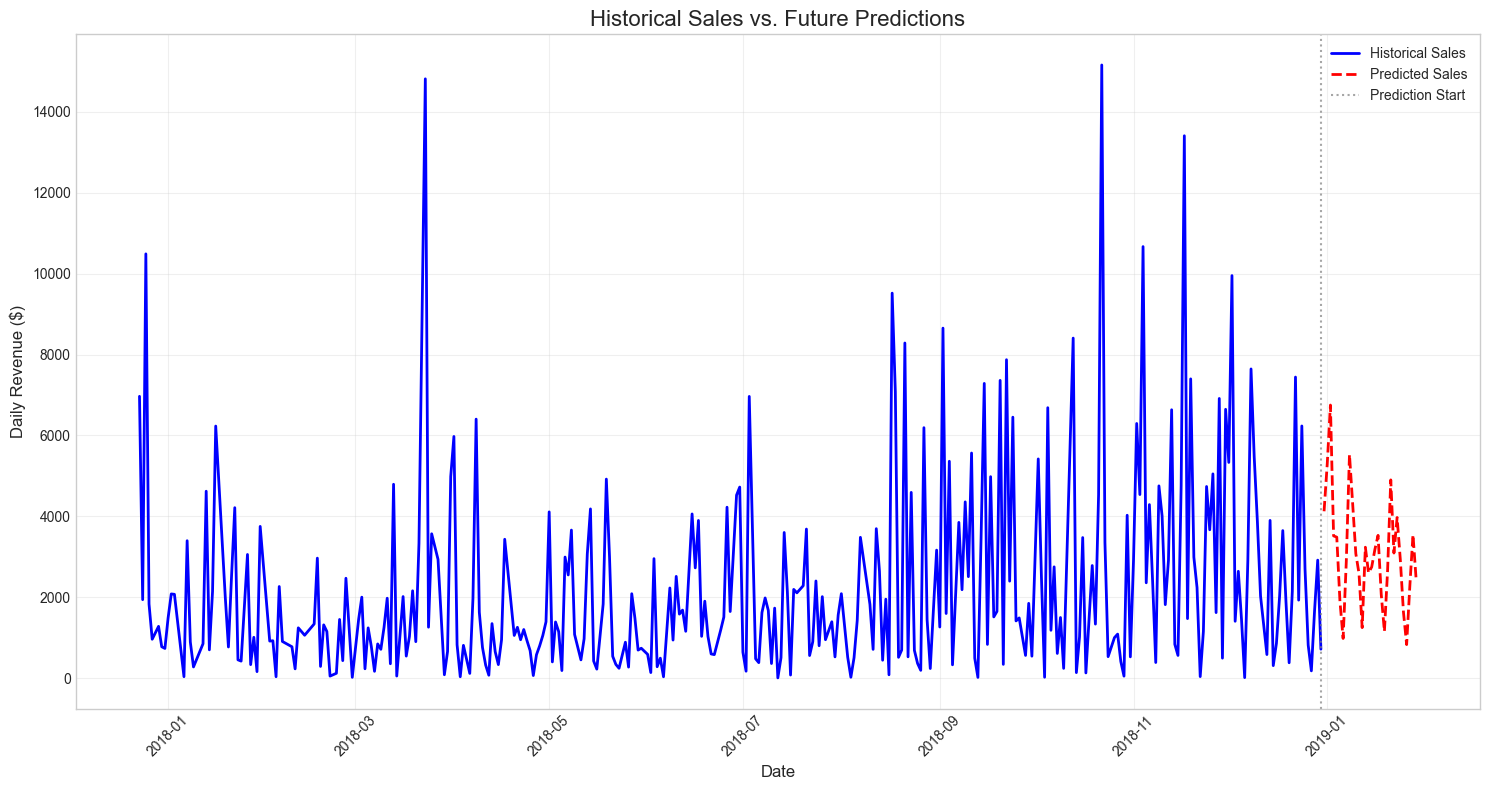

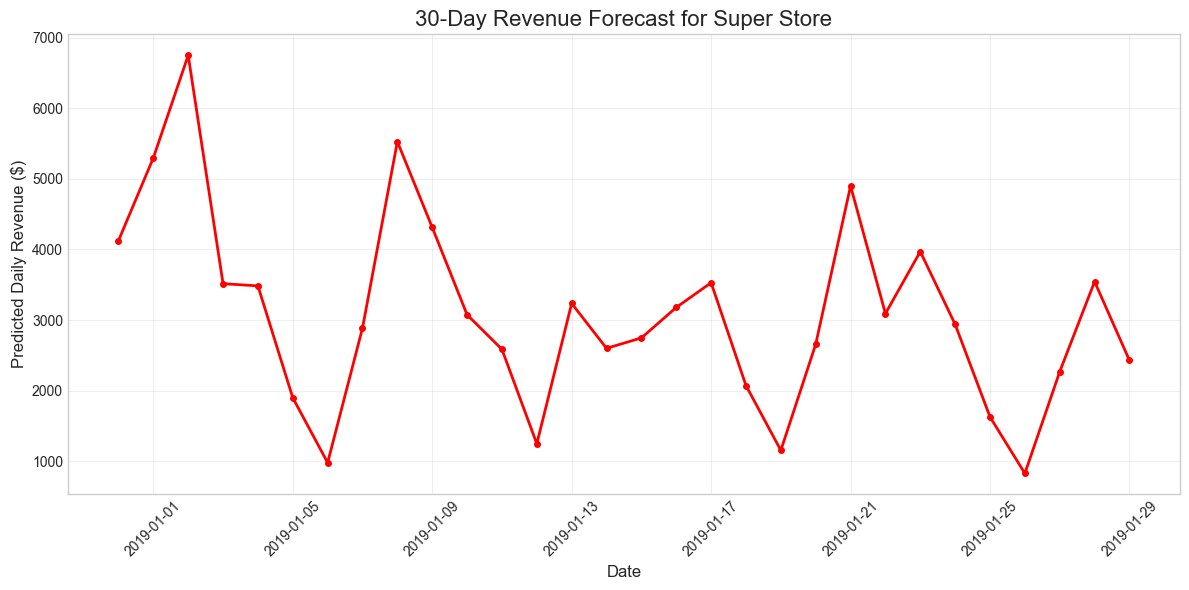

In [10]:
# Create a comprehensive plot showing historical data and future predictions
plot_predictions_with_history(df_for_prediction, future_predictions, days_to_show=330)

# Also create a zoomed-in view of just the prediction period
plt.figure(figsize=(12, 6))
plt.plot(future_predictions['date'], future_predictions['predicted_revenue'], 
         marker='o', color='red', linewidth=2, markersize=4)
plt.title("30-Day Revenue Forecast for Super Store", fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Predicted Daily Revenue ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [11]:
# Generate a comprehensive summary of the predictions
summarize_predictions(future_predictions)

# Save the predictions for business use
FUTURE_PREDICTIONS_FILE = os.path.join(DATA_DIR, 'super_store_30_day_forecast.csv')
future_predictions.to_csv(FUTURE_PREDICTIONS_FILE, index=False)
print(f"\n💾 30-day forecast saved to: {FUTURE_PREDICTIONS_FILE}")

# Create additional business-relevant analysis
print("\n" + "="*60)
print("🎯 ACTIONABLE BUSINESS INSIGHTS")
print("="*60)

# Find peak and low revenue days
max_day = future_predictions.loc[future_predictions['predicted_revenue'].idxmax()]
min_day = future_predictions.loc[future_predictions['predicted_revenue'].idxmin()]

print(f"\n📈 Peak Revenue Day:")
print(f"  • Date: {max_day['date'].strftime('%A, %B %d, %Y')}")
print(f"  • Predicted Revenue: ${max_day['predicted_revenue']:.2f}")

print(f"\n📉 Lowest Revenue Day:")
print(f"  • Date: {min_day['date'].strftime('%A, %B %d, %Y')}")
print(f"  • Predicted Revenue: ${min_day['predicted_revenue']:.2f}")

# Calculate revenue variance for inventory planning
revenue_std = future_predictions['predicted_revenue'].std()
revenue_mean = future_predictions['predicted_revenue'].mean()
cv = (revenue_std / revenue_mean) * 100

print(f"\n📊 Variability Insights:")
print(f"  • Revenue Standard Deviation: ${revenue_std:.2f}")
print(f"  • Coefficient of Variation: {cv:.1f}%")

if cv < 10:
    print("  → Low variability: Stable inventory planning possible")
elif cv < 20:
    print("  → Moderate variability: Plan for some fluctuation")
else:
    print("  → High variability: Consider flexible inventory strategies")


🔮 Future Sales Forecast Summary
Prediction Period: 2018-12-31 to 2019-01-29
Number of Days: 30

📊 Revenue Predictions:
  • Average Daily Revenue: $3081.17
  • Minimum Daily Revenue: $826.76
  • Maximum Daily Revenue: $6750.05
  • Total Predicted Revenue: $92435.23

📈 Weekly Breakdown:
  • Week 1: Avg $3720.88/day, Total $26046.18
  • Week 2: Avg $3266.50/day, Total $22865.47
  • Week 3: Avg $2561.69/day, Total $17931.84
  • Week 4: Avg $2802.80/day, Total $19619.61
  • Week 5: Avg $2986.06/day, Total $5972.13

💾 30-day forecast saved to: data/super_store_sales\super_store_30_day_forecast.csv

🎯 ACTIONABLE BUSINESS INSIGHTS

📈 Peak Revenue Day:
  • Date: Wednesday, January 02, 2019
  • Predicted Revenue: $6750.05

📉 Lowest Revenue Day:
  • Date: Saturday, January 26, 2019
  • Predicted Revenue: $826.76

📊 Variability Insights:
  • Revenue Standard Deviation: $1375.78
  • Coefficient of Variation: 44.7%
  → High variability: Consider flexible inventory strategies
